In [1]:
import __init__
import models.cross_validator as cross_validator
import models.datahandler as datahandler
from models.datamodel import DataModel
import models.outputmaker as outputmaker
import evaluator.metrics as metrics

trial = datahandler.load_train('../data/dataset/tsd_trial.csv', verbose=True)
train = datahandler.load_train('../data/dataset/tsd_train.csv', verbose=True)

/home/hb/.local/lib/python3.6/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."


In [6]:
datamodel = DataModel(model='crf', remove_stop_words=True)

output_maker = outputmaker.crf_output

evaluator = metrics

In [7]:
X_train, y_train, train_taboo_words, train_texts = cross_validator.load_data(train, 
                                                                             [i for i in range(train.shape[0])],
                                                                             datamodel, 
                                                                             logger=True)

X_test, y_test, test_taboo_words, test_texts = cross_validator.load_data(trial, 
                                                                         [i for i in range(trial.shape[0])], 
                                                                         datamodel, 
                                                                         logger=True)

100%|██████████| 690/690 [00:11<00:00, 59.57it/s]


In [8]:
words = set([w for x in X_train for w, tag, label in x])
chars = set([char for x in X_train for w, tag, label in x for char in w])
tags = set([tag for x in X_train for w, pos, tag in x])

n_tags = len(tags)
n_chars = len(chars)
n_words = len(words)

n_tags, n_chars, n_words 

(2, 132, 22682)

In [9]:
print(chars)

{'&', '🤥', '_', 'S', '}', '🆘', '2', 'ó', 'u', 'ˈ', 'r', '{', '😁', '😈', 'a', 'P', 'l', 'ʻ', '^', '"', '💥', '”', 'e', 'Z', '[', '😆', 'ü', '😜', 'c', '3', 'F', '\x7f', 'E', 'J', 'm', '☠', '😂', 'o', 'R', 'q', 'H', ',', '0', '4', 'G', '•', 'Y', '-', '#', '9', '😞', 'ï', '😊', 'D', '$', '😉', 'B', 's', 'é', '%', 'X', '😬', 'Q', '?', 'V', '5', '⚾', '😵', 'b', '`', '😅', '⚽', 'z', '💀', '»', 'n', '✭', 'A', 'K', 'W', '*', '͞', 'f', ')', '1', 'I', '!', 'N', '+', '\\', '―', 'p', 'M', '@', '6', 'U', '(', '/', 'h', 'j', 'C', '.', '🔥', 'x', 'y', '💨', '▀', 'd', ':', '=', '️', '’', '🙄', '«', '😡', ']', 'ê', 'w', "'", 'L', '8', 'v', ';', 'g', '\u200b', 'O', 'k', 'i', 't', '7', 'T', '¬'}


In [10]:
max([len(x) for x in X_train]), max([len(w) for x in X_train for w, tag, label in x])

(157, 198)

In [11]:
max_len = 157
max_len_char = 198

In [12]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [13]:
print(word2idx["fuck"])
print(tag2idx["normal"])

13279
2


In [14]:
from keras.preprocessing.sequence import pad_sequences

X_word = [[word2idx[w[0]] for w in s] for s in X_train]

Using TensorFlow backend.


In [15]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [16]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [17]:
import numpy as np

X_char = []
for sentence in X_train:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [18]:
y = [[tag2idx[w[2]] for w in s] for s in X_train]

len(y)

7939

In [19]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [20]:
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [21]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [22]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [62]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 183, 133)     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 183)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 183, 133, 10) 980         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 183, 20)      134760      input_1[0][0]                    
____________________________________________________________________________________________

In [63]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

/home/hb/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 760 samples, validate on 85 samples
Epoch 1/10
760/760 [==============================] - 55s 73ms/step - loss: 0.1829 - acc: 0.8834 - val_loss: 0.1219 - val_acc: 0.9292
Epoch 2/10
760/760 [==============================] - 47s 62ms/step - loss: 0.0752 - acc: 0.9128 - val_loss: 0.0591 - val_acc: 0.9292
Epoch 3/10
760/760 [==============================] - 47s 62ms/step - loss: 0.0562 - acc: 0.9128 - val_loss: 0.0570 - val_acc: 0.9292
Epoch 4/10
760/760 [==============================] - 46s 61ms/step - loss: 0.0559 - acc: 0.9128 - val_loss: 0.0565 - val_acc: 0.9292
Epoch 5/10
760/760 [==============================] - 46s 61ms/step - loss: 0.0548 - acc: 0.9128 - val_loss: 0.0562 - val_acc: 0.9292
Epoch 6/10
760/760 [==============================] - 46s 61ms/step - loss: 0.0544 - acc: 0.9128 - val_loss: 0.0558 - val_acc: 0.9292
Epoch 7/10
760/760 [==============================] - 46s 61ms/step - loss: 0.0542 - acc: 0.9128 - val_loss: 0.0564 - val_acc: 0.9292
Epoch 8/10
760/76

In [65]:
import pandas as pd 
hist = pd.DataFrame(history.history)


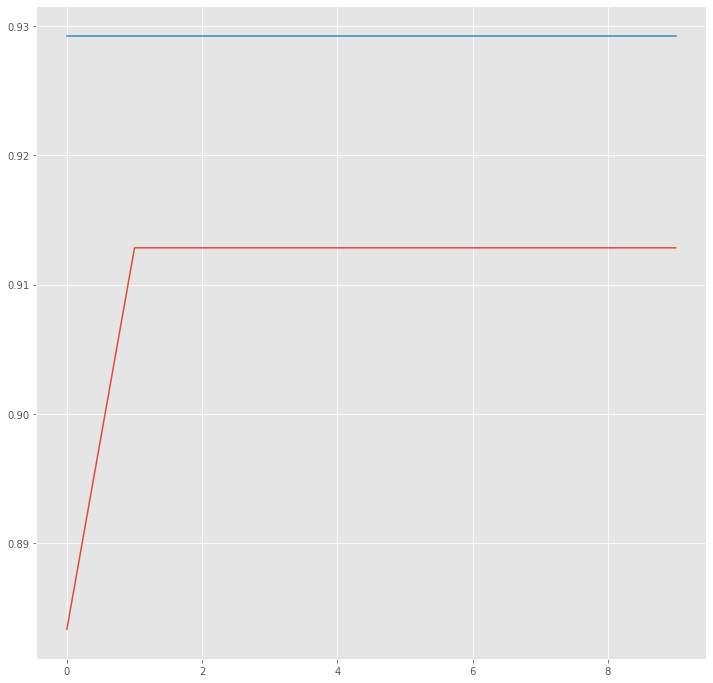

In [66]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [67]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [69]:
y_pred[0][0]

array([0.00304785, 0.97804594, 0.11707327], dtype=float32)

In [84]:
i = 16
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
Here           : normal normal
is             : normal normal
a              : normal normal
better         : normal normal
idea           : normal normal
reduce         : normal normal
the            : normal normal
tax            : normal normal
&              : normal normal
regulatory     : normal normal
burden         : normal normal
so             : normal normal
that           : normal normal
the            : normal normal
U.S.           : normal normal
companies      : normal normal
are            : normal normal
not            : normal normal
forced         : normal normal
to             : normal normal
look           : normal normal
elsewhere      : normal normal
in             : normal normal
order          : normal normal
to             : normal normal
survive        : normal normal
Unfortunately  : normal normal
the            : normal normal
Obama          : normal normal
Democrats      : normal normal
are            : normal normal
economic  

In [ ]:
test, y_test, test_taboo_words, test_texts 



In [ ]:
X_word_test = [[word2idx[w[0]] for w in s] for s in X_test]

X_word_test = pad_sequences(maxlen=max_len, sequences=X_word_test, 
                            value=word2idx["PAD"], padding='post', truncating='post')


X_char_test = []
for sentence in X_test:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char_test.append(np.array(sent_seq))